In [1]:
import os
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
import sklearn
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [3]:
n_jobs = 64
_svm = svm.SVC(gamma='scale', kernel='rbf', class_weight='balanced')
clf = make_pipeline(StandardScaler(), _svm)
raw_decoder = make_pipeline(mne.decoding.Vectorizer(), clf)
time_decoder = mne.decoding.SlidingEstimator(clf, n_jobs=n_jobs, scoring='f1')
skf = StratifiedKFold(n_splits=10)
xdawn = mne.preprocessing.Xdawn(n_components=6, reg='diagonal_fixed')

In [4]:
fifs = pd.read_json('fifs.json')
fifs

,rawpath,icapath
S01_R04,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_l...,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_R...
S01_R05,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_l...,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_R...
S01_R06,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_l...,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_R...
S01_R07,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_l...,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_R...
S01_R08,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_l...,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_R...
S01_R09,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_l...,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_R...
S01_R10,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_l...,rawdata/20190326_RSVP_MEG_zhangchuncheng/S01_R...
S02_R04,rawdata/20190326_RSVP_MEG_maxuelin/S02_lixiang...,rawdata/20190326_RSVP_MEG_maxuelin/S02_R04-cle...
S02_R05,rawdata/20190326_RSVP_MEG_maxuelin/S02_lixiang...,rawdata/20190326_RSVP_MEG_maxuelin/S02_R05-cle...
S02_R06,rawdata/20190326_RSVP_MEG_maxuelin/S02_lixiang...,rawdata/20190326_RSVP_MEG_maxuelin/S02_R06-cle...


In [5]:
iter_freqs = [
    ('Delta', 0, 4),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [6]:
tmin, tmax = -0.2, 1.2
picks = 'mag'
rawraw = mne.concatenate_raws([mne.io.read_raw_fif(fifs.loc['S02_R{:02d}'.format(j)]['icapath']) for j in range(4, 12)])
results = dict()
freqs = iter_freqs[0]
print('-' * 80)
print(freqs)
name_freq, l_freq, h_freq = freqs

# Load raw
raw = rawraw.copy()
events = mne.find_events(raw, stim_channel='UPPT001')

Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R04-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R05-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R06-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R07-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R08-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   2

In [7]:
import tqdm
sfreq = raw.info['sfreq']
pbar = tqdm.tqdm(events[events[:, -1]==1])
for e in pbar:
    pbar.set_description('Index: {}'.format(e[0]))
    for ee in events:
        if all([ee[-1] == 2, abs(ee[0]-e[0])<sfreq]):
            ee[-1] = 4

Index: 2789498: 100%|██████████| 448/448 [00:16<00:00, 27.79it/s]


Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R04-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R05-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R06-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R07-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   299.999 secs
Ready.
Current compensation grade : 3
Opening raw data file rawdata/20190326_RSVP_MEG_maxuelin/S02_R08-clean-raw.fif...
    Read 5 compensation matrices
    Range : 0 ... 359999 =      0.000 ...   2

<ipython-input-8-3795fe0234e0>:19: RuntimeWarning: The measurement information indicates a low-pass frequency of 600 Hz. The decim=10 parameter will result in a sampling frequency of 120 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, picks=picks, tmin=tmin, tmax=tmax, decim=10)


0 bad epochs dropped
Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 199 samples (1.658 sec)



<ipython-input-8-3795fe0234e0>:23: RuntimeWarning: filter_length (199) is longer than the signal (169), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=l_freq, h_freq=h_freq)


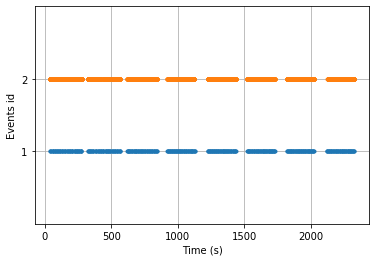

{'1': 1, '2': 2}
1


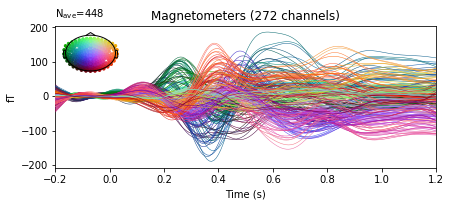

2


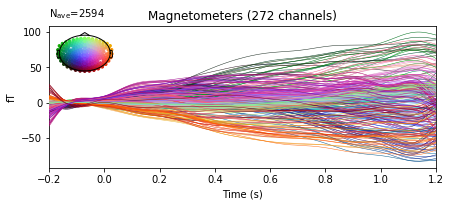

(3042, 272, 169) (3042,)
(3042,) (3042, 169)
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[       

<ipython-input-8-3795fe0234e0>:19: RuntimeWarning: The measurement information indicates a low-pass frequency of 600 Hz. The decim=10 parameter will result in a sampling frequency of 120 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, picks=picks, tmin=tmin, tmax=tmax, decim=10)


0 bad epochs dropped
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 199 samples (1.658 sec)



<ipython-input-8-3795fe0234e0>:23: RuntimeWarning: filter_length (199) is longer than the signal (169), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=l_freq, h_freq=h_freq)


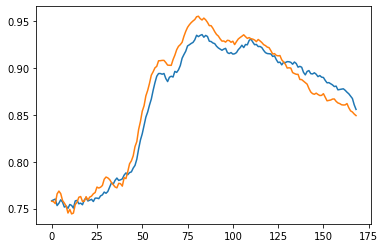

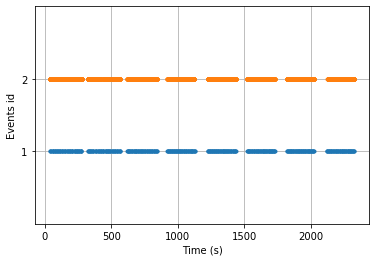

{'1': 1, '2': 2}
1


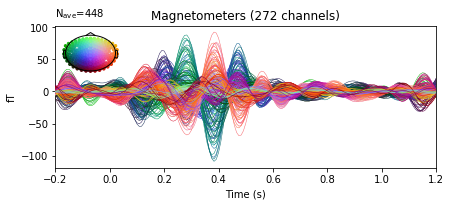

2


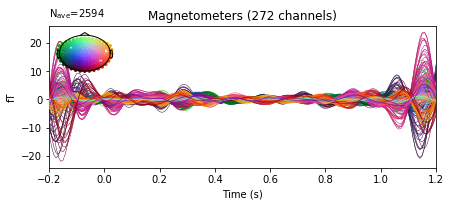

(3042, 272, 169) (3042,)
(3042,) (3042, 169)
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[       

<ipython-input-8-3795fe0234e0>:19: RuntimeWarning: The measurement information indicates a low-pass frequency of 600 Hz. The decim=10 parameter will result in a sampling frequency of 120 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, picks=picks, tmin=tmin, tmax=tmax, decim=10)


0 bad epochs dropped
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 199 samples (1.658 sec)



<ipython-input-8-3795fe0234e0>:23: RuntimeWarning: filter_length (199) is longer than the signal (169), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq=l_freq, h_freq=h_freq)


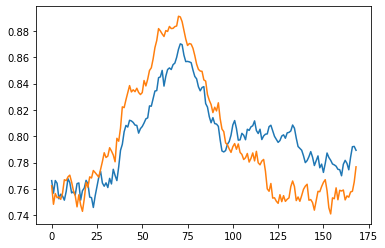

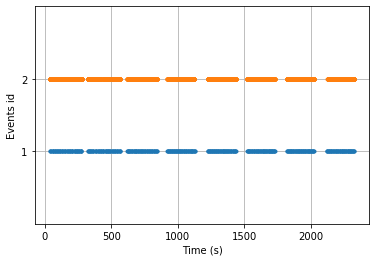

{'1': 1, '2': 2}
1


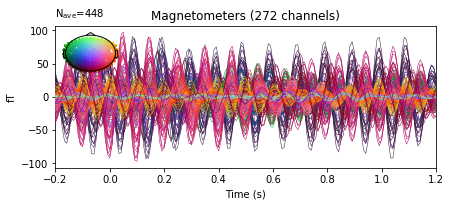

2


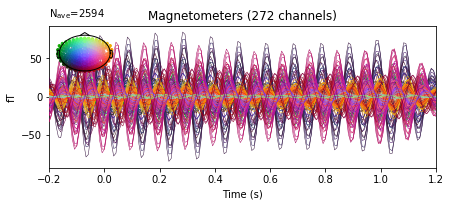

(3042, 272, 169) (3042,)
(3042,) (3042, 169)
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[       

<ipython-input-8-3795fe0234e0>:19: RuntimeWarning: The measurement information indicates a low-pass frequency of 600 Hz. The decim=10 parameter will result in a sampling frequency of 120 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, picks=picks, tmin=tmin, tmax=tmax, decim=10)


0 bad epochs dropped
Setting up band-pass filter from 13 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-6 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 25.00 Hz
- Upper transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 28.12 Hz)
- Filter length: 123 samples (1.025 sec)



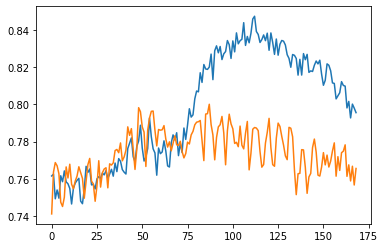

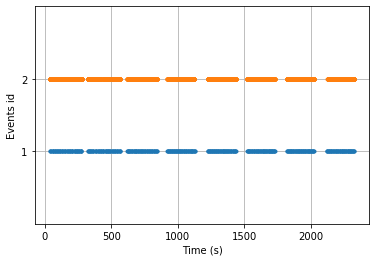

{'1': 1, '2': 2}
1


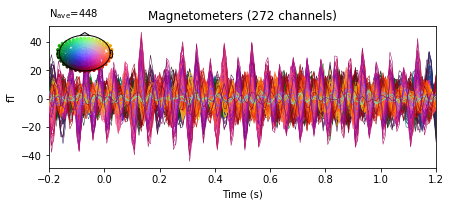

2


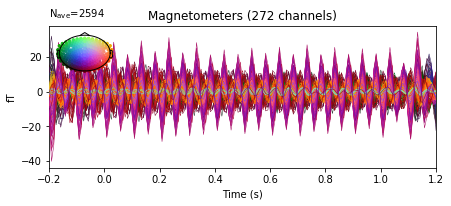

(3042, 272, 169) (3042,)
(3042,) (3042, 169)
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[       

<ipython-input-8-3795fe0234e0>:19: RuntimeWarning: The measurement information indicates a low-pass frequency of 600 Hz. The decim=10 parameter will result in a sampling frequency of 120 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, events, picks=picks, tmin=tmin, tmax=tmax, decim=10)


0 bad epochs dropped
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 53 samples (0.442 sec)



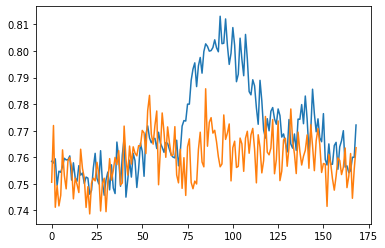

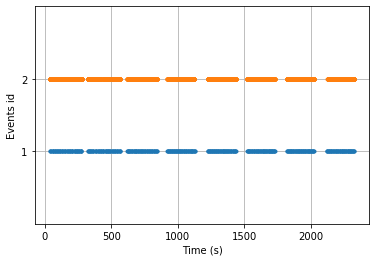

{'1': 1, '2': 2}
1


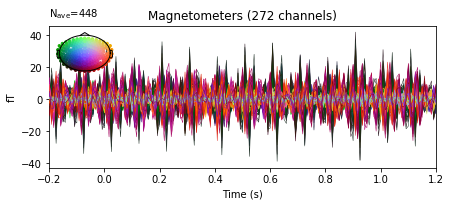

2


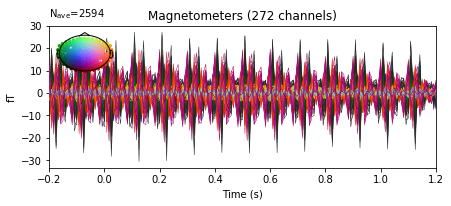

(3042, 272, 169) (3042,)
(3042,) (3042, 169)
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[                                                            ]   0.00% Transforming SlidingEstimator |
.
..
...
[                                                            ]   0.00% Fitting SlidingEstimator |
[       

/home/zcc/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/zcc/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(3042, 272, 169) (3042,)
(3042,) (3042, 169)
Computing data rank from raw with rank='full'
    MAG: rank 272 from info
Reducing data rank from 272 -> 272
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Computing data rank from raw with rank='full'
    MAG: rank 272 from info
Reducing data rank from 272 -> 272
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Computing data rank from raw with rank='full'
    MAG: rank 272 from info
Reducing data rank from 272 -> 272
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
Done.
Transforming to Xdawn space
Zeroing out 266 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 266 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 266 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 266 Xdawn components
Inverse transforming to sensor space
[ 

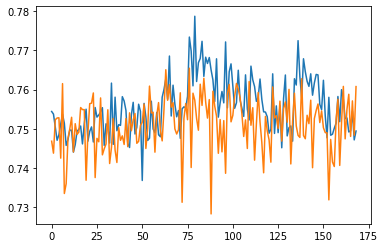

In [8]:
tmin, tmax = -0.2, 1.2
picks = 'mag'
rawraw = mne.concatenate_raws([mne.io.read_raw_fif(fifs.loc['S02_R{:02d}'.format(j)]['icapath']) for j in range(4, 12)])
results = dict()
for freqs in iter_freqs:
    print('-' * 80)
    print(freqs)
    name_freq, l_freq, h_freq = freqs
    
    # Load raw
    raw = rawraw.copy()
    # raw.load_data()
    
    # Filter
    # raw.filter(l_freq=l_freq, h_freq=h_freq)

    # Get epochs
    # Raw epochs
    epochs = mne.Epochs(raw, events, picks=picks, tmin=tmin, tmax=tmax, decim=10)
    # Clear events
    epochs = epochs[['1', '2']]
    epochs.load_data()
    epochs.filter(l_freq=l_freq, h_freq=h_freq)

    event_id = epochs.event_id
    # Get and plot events
    events = epochs.events
    mne.viz.plot_events(events, sfreq=raw.info['sfreq'])
    print(event_id)
    # Plot epochs
    for event in event_id:
        print(event)
        epochs[event].average().plot(spatial_colors=True)

    # MVPA raw
    # Get X, y
    X = epochs.get_data()
    y = events[:, -1]
    print(X.shape, y.shape)
    # Prepare predicts
    y_predict = np.zeros(X.shape[0])
    y_time_predict = np.zeros((X.shape[0], X.shape[2]))
    print(y_predict.shape, y_time_predict.shape)
    # Cross validation
    for train, test in skf.split(X, y):
        # Split train and test
        print('.')
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]
        # All time train and test
        print('..')
        raw_decoder.fit(X_train, y_train)
        y_predict[test] = raw_decoder.predict(X_test)
        # Window time train and test
        print('...')
        time_decoder.fit(X_train, y_train)
        y_time_predict[test, :] = time_decoder.predict(X_test)
    # Reports
    # All time report
    print(sklearn.metrics.classification_report(y_pred=y_predict, y_true=y))
    print(sklearn.metrics.precision_score(y_pred=y_predict, y_true=y, average='weighted'))
    # Window time report
    scores = np.zeros(y_time_predict.shape[1])
    for j, y_pred in enumerate(y_time_predict.transpose()):
        scores[j] = sklearn.metrics.precision_score(y_pred=y_pred, y_true=y, average='weighted')
    plt.plot(scores)

    # MVPA xdawn
    epochs.baseline = None
    # Get X, y
    X = epochs.get_data()
    y = events[:, -1]
    print(X.shape, y.shape)
    # Prepare predicts
    xdawn_y_predict = np.zeros(X.shape[0])
    xdawn_y_time_predict = np.zeros((X.shape[0], X.shape[2]))
    print(xdawn_y_predict.shape, xdawn_y_time_predict.shape)
    # Cross validation
    for train, test in skf.split(X, y):
        # Split train and test
        # Transoform using xdawn
        # X_train, y_train = xdawn.fit_transform(epochs[train]), y[train]
        # X_test, y_test = xdawn.transform(epochs[test]), y[test]
        xdawn.fit(epochs[train])
        X_train, y_train = xdawn.apply(epochs[train])['1'].get_data(), y[train]
        X_test, y_test = xdawn.apply(epochs[test])['1'].get_data(), y[test]
        # All time train and test
        raw_decoder.fit(X_train, y_train)
        xdawn_y_predict[test] = raw_decoder.predict(X_test)
        # Window time train and test
        time_decoder.fit(X_train, y_train)
        xdawn_y_time_predict[test, :] = time_decoder.predict(X_test)
    # Reports
    # All time report
    print(sklearn.metrics.classification_report(y_pred=xdawn_y_predict, y_true=y))
    print(sklearn.metrics.precision_score(y_pred=xdawn_y_predict, y_true=y, average='weighted'))
    # Window time report
    xdawn_scores = np.zeros(xdawn_y_time_predict.shape[1])
    for j, y_pred in enumerate(xdawn_y_time_predict.transpose()):
        xdawn_scores[j] = sklearn.metrics.precision_score(y_pred=y_pred, y_true=y, average='weighted')
    plt.plot(xdawn_scores)
    
    # Save results
    results[name_freq] = dict(
        y_true = y,
        y_pred = y_predict,
        y_time_pred = y_time_predict,
        xdawn_y_pred = xdawn_y_predict,
        xdawn_y_time_pred = xdawn_y_time_predict,
    )

In [9]:
import pandas as pd
df = pd.DataFrame(results)
df = df.T
df.to_json('MVPAresults_S02.json')
df

,y_true,y_pred,y_time_pred,xdawn_y_pred,xdawn_y_time_pred
Delta,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
Theta,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0,..."
Alpha,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...","[2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0,..."
Beta,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, ...","[[2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
Gamma,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0,...","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[[1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0,..."
